In [2]:
# model - res - val - test - pubtest
08-09-22:18-01 - 224 - 0.352130104126733  - 0.34340073397977544 - 0.320513 (for wrong shape)
09-09-22:03-43 - 224 - 0.356592538804201  - 0.36580433370481114 - 
09-09-22:04-11 - 224 - 0.3749587571763273 - 0.36580433370481114
09-09-22:04-30 - 244 - 0.3822467357219062 - 0.36625924432059936
09-09-22:05-15 - 224 - 0.389954398893404  - 0.3836744421190182
09-09-22:07-00 - 244 - 0.3799090902411123 - 0.36977115531546856
## res up 336
09-09-22:07-13 - 336 - 0.4637629689412524 - 0.45099478690519057
09-09-22:07-51 - 336 - 0.4824657184487458 - 0.4579317445148534
09-09-22:08-11 - 336 - 0.4895273761230748 - 0.4732696128734981
09-09-22:10-06 - 336 -                    - 0.4593754198641869
09-09-22:10-55 - 336 - 0.4934589107964149 - 0.47089401938018594
09-09-22:11-44 - 336 - 
09-09-22:12-20 - 336 -                    - 0.4666477416992787
09-09-22:16-43 - 336 -                    - 0.4712745856154329
09-09-22:17-23 - 336 - # Blur fail 0.4561347085711673
10-09-22:04-19 - 336 -                    - 0.47795264928984343
10-09-22:04-51 - 336 - # GlassBlur        - 0.46458984518569313 iter=1

#    
10-09-22:14-46 - 336 -                    - 0.4788394224904983
11-09-22:04-39 - 336 -                    - 0.4726661909735389 # MotionBlur ?

11-09-22:07-43 - 336 -                    - 0.4741710100815526
11-09-22:08-28 - 336 -                    - 0.4890214403792833
11-09-22:08-48 - 336 -                    - 0.4724943194448729 

#res up 384
11-09-22:13-31 - 384 -                    - 0.4940599275229879 - 0.477298
11-09-22:14-04 - 384 -                    - 0.5017234734495283
11-09-22:14-12 - 384 -                    - 0.5025646359270989
11-09-22:16-58 - 384 - 0.5076024792941374 - 0.5037055911809165 - 0.475772
12-09-22:01-47 - 384 -
    
    
13-09-22:01-03 - 384 -                    -                    - 0.483468

## Folds validation

In [72]:
!ls baseline

08-09-22:18-01_logger_name.txt		nohup.out
08-09-22:18-01_model_unet_baseline.pth	train_unet_baseline.py


In [3]:
import os
from pathlib import Path

datapath = Path('/home/rost/workspaces/challenges/eye/data/raw/')

trainpath = datapath / 'train_dataset_mc'
testpath = datapath / 'test_dataset_mc2/eye_test'

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
import cv2

from skimage import io
from torch.utils.data import Dataset, DataLoader

class EyeDataset(Dataset):
    def __init__(self, datadir, names, aug = None):
        self.datadir = datadir
        self.aug = aug
        self._imgpathes = [ datadir / (name + '.png') for name in names ]
        self._maskpathes = [ datadir / (name + '.geojson') for name in names ]

    @staticmethod
    def parse_polygon(coordinates, image_size):
        mask = np.zeros(image_size, dtype=np.float32)

        if len(coordinates) == 1:
            points = [np.int32(coordinates)]
            cv2.fillPoly(mask, points, 1)
        else:
            points = [np.int32([coordinates[0]])]
            cv2.fillPoly(mask, points, 1)

            for polygon in coordinates[1:]:
                points = [np.int32([polygon])]
                cv2.fillPoly(mask, points, 0)

        return mask

    @staticmethod
    def parse_mask(shape, image_size):
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)

        return mask

    def read_layout(self, maskpath, image_size):
        with open(maskpath, 'r', encoding='cp1251') as f:
            json_contents = json.load(f)

        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            mask += self.parse_mask(shape['geometry'], image_size)

        return mask.clip(max=1)
        
    def __getitem__(self, idx):
        imgpath = self._imgpathes[idx]
        img = io.imread(imgpath)

        maskpath = self._maskpathes[idx]
        mask = self.read_layout(maskpath, img.shape[:-1])

        if self.aug is not None:
            auged = self.aug(image=img, mask=mask)
            img = auged['image']

        img = np.moveaxis(img, -1, 0)
        
        return img, mask

    def __len__(self):
        return len(self._imgpathes)

In [6]:
from nn_tools.metrics.segmentation import f1_score 

In [7]:
from nn_tools.models import UnetSm

def get_predicts(resolution, model_path, names):
    height = resolution
    width = int(resolution / 0.7586206896551724)

    if width % 2 == 1:
        width += 1
    
    tdataset = EyeDataset(trainpath, names,
        aug=A.Resize( height=height, 
                      width=width, 
                      p=1. ))
        
    infer_loader = DataLoader(
        tdataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    model = UnetSm( in_channels=3,
                    out_channels=2,
                    encoder_name='efficientnet-b3',
                    encoder_weights=None,
                    decoder_attention_type='scse')

    state = torch.load(model_path, map_location=torch.device('cpu'))

    model.load_state_dict(state)
    model.eval()
    model.cuda(0)

    apreds = list()
    amasks = list()

    for imgs_batch, mask_batch in tqdm(infer_loader):
        with torch.no_grad():
            preds = model(imgs_batch.float().cuda(0))
            preds = preds.data.cpu().numpy()

            apreds.append(preds)
            amasks.append(mask_batch)

    apreds = np.vstack(apreds)
    amasks = np.vstack(amasks)

    return apreds, amasks

In [8]:
import albumentations as A
from nn_tools.models import UnetSm

batch_size = 4
num_workers = 4

In [9]:
import torch
import numpy as np

from tqdm import tqdm

In [10]:
f1 = lambda TP, FP, FN,: 2*TP / (2*TP + FP + FN)

In [163]:
import json

with open('balanced/bsplit13.json') as f:
    split13 = json.load(f)

In [ ]:
13-09-22:05-00 - 0.40339787159620893 - 0.43736799152985784 - 0.461077
13-09-22:06-31 - 0.4319331475800715  - 0.46011350370730775 - 0.468370
13-09-22:08-15 - 0.46513920124090696 - 0.5011637742119965  - 0.490826
13-09-22:10-07 - 0.47763166253171147 - 0.5024334213780037  - 0.467126
13-09-22:12-09 - 0.5024334213780037  - 0.5369477140954092  - 0.486768

In [213]:
import json

with open('splits/split1.json') as f:
    split = json.load(f)

In [ ]:
11-09-22:16-58 - 0.5076024792941374 - 0.5037055911809165 - 0.482606
unet_sp1       - 0.5731170564318692 - 0.5620863712401309 - 0.532507

In [202]:
import json

with open('eqsplit_100/split2.json') as f:
    split = json.load(f)

In [ ]:
13-09-22:17-42 - 0.5123442558299688 - 0.4944356490149324 - 0.483616
13-09-22:20-04 - 0.5010284238444785 - 0.5056504949100198 - 0.472902
13-09-22:22-28 - 0.5267818453287507 - 0.5405804730080526 - 0.483684
14-09-22:00-40 - 0.55483262853889   - 0.5303131916302135 - 0.493939

In [217]:
model_path = 'baseline/' + 'unet_sp1.bin' 

resolution = 580

apreds, amasks = get_predicts(resolution, model_path, split['val'])

100%|██████████| 33/33 [00:07<00:00,  4.18it/s]


In [43]:
import skimage

In [218]:
mf1 = list()

for prob, mask in tqdm([*zip(apreds, amasks)]):
    prob = np.swapaxes(np.swapaxes(prob, 0, 1), 1, 2)
    rprob = cv2.resize(prob, mask.shape[::-1], interpolation=cv2.INTER_CUBIC)
    pred = rprob.argmax(2)
    true = mask.astype(np.uint8)

    TP = np.sum((true == pred) & true)
    FP = np.sum((true != pred) & np.logical_not(true))
    FN = np.sum((true != pred) & np.logical_not(pred))

    mf1.append(f1(TP, FP, FN))

print(np.mean(mf1))

100%|██████████| 65/65 [00:01<00:00, 34.61it/s]

0.5731170564318692


In [11]:
import cv2

from skimage import io
from torch.utils.data import Dataset, DataLoader

class EyeDatasetInfer(Dataset):
    def __init__(self, datadir, names, aug = None):
        self.datadir = datadir
        self.aug = aug
        self._imgpathes = [ datadir / (name + '.png') for name in names ]

    def __getitem__(self, idx):
        imgpath = self._imgpathes[idx]
        img = io.imread(imgpath)


        if self.aug is not None:
            auged = self.aug(image=img)
            img = auged['image']

        img = np.moveaxis(img, -1, 0)
        
        return img

    def __len__(self):
        return len(self._imgpathes)

In [12]:
def get_infers(resolution, model_path, names, bone='efficientnet-b3'):
    height = resolution
    width = int(resolution / 0.7586206896551724)

    if width % 2 == 1:
        width += 1
    
    tdataset = EyeDatasetInfer(testpath, names,
        aug=A.Resize( height=height, 
                      width=width, 
                      p=1. ))

    infer_loader = DataLoader(
        tdataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    model = UnetSm( in_channels=3,
                    out_channels=2,
                    encoder_name=bone,
                    encoder_weights=None,
                    decoder_attention_type='scse')

    state = torch.load(model_path, map_location=torch.device('cpu'))

    model.load_state_dict(state)
    model.eval()
    model.cuda(0)

    apreds = list()

    for imgs_batch in tqdm(infer_loader):
        preds = model(imgs_batch.float().cuda(0))
#         preds = model(imgs_batch.float())

        preds = preds.data.cpu().numpy()

        apreds.append(preds)

    apreds = np.vstack(apreds)

    return apreds

In [13]:
timgs = [p.stem for p in Path('data/raw/test_dataset_mc2/eye_test/').glob('*.png')]
simgs = [p.stem for p in Path('data/raw/Микроциркуляция/sample_solution/').glob('*.png')]

cimgs = [*set(set(simgs) & set(timgs))]
ncimgs = [* set(simgs) - set(set(simgs) & set(timgs))]

In [14]:
len(timgs)

301

In [18]:
model_path = 'models/sp3_unet.pth' 

resolution = 924
batch_size = 1

apreds = get_infers(resolution, model_path, timgs)

  0%|          | 0/301 [00:00<?, ?it/s]/home/rost/workspaces/challenges/eye/.venv/lib/python3.8/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
100%|██████████| 301/301 [00:31<00:00,  9.53it/s]


In [19]:
import zipfile

In [20]:
simgs = [p.stem for p in Path('data/raw/Микроциркуляция/sample_solution/').glob('*.png')]
subimgs = [p.stem for p in Path('submit/').glob('*.png')]

In [21]:
densenet121!rm submit.zip

with zipfile.ZipFile(f'submit.zip', 'w', zipfile.ZIP_DEFLATED) as f:
    for prob, stem in tqdm(zip(apreds, timgs)):
        prob = np.swapaxes(np.swapaxes(prob, 0, 1), 1, 2)
        rprob = cv2.resize(prob, (1624, 1232), interpolation=cv2.INTER_CUBIC)
        pred = rprob.argmax(2) * 255

        io.imsave(f'submit/{stem}.png', pred)
        f.write(f'submit/{stem}.png', f'{stem}.png')

0it [00:00, ?it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/871.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
1it [00:00,  4.09it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/845.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
2it [00:00,  4.47it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/943.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
3it [00:00,  4.66it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/847.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to 

30it [00:05,  5.26it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1054.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
31it [00:06,  5.06it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/976.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
32it [00:06,  5.04it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/990.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
33it [00:06,  5.16it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/890.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from 

60it [00:11,  5.55it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1087.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
61it [00:11,  5.45it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/965.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
62it [00:12,  5.31it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/947.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
63it [00:12,  5.44it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1096.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from

90it [00:16,  6.52it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/825.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
91it [00:16,  6.92it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1017.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
92it [00:16,  7.27it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/927.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
93it [00:16,  7.56it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/948.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from 

120it [00:21,  6.31it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1028.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
121it [00:21,  6.24it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/886.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
122it [00:21,  6.35it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1035.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/826.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Ran

151it [00:24,  9.71it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1085.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
152it [00:24,  8.47it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/954.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
153it [00:24,  8.54it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1029.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
154it [00:24,  8.66it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1103.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion

182it [00:27, 10.23it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/816.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1116.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
184it [00:28,  9.79it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/864.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
185it [00:28,  9.40it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/892.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Rang

212it [00:32,  5.61it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1060.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
213it [00:32,  5.63it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1031.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
214it [00:33,  5.79it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1044.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
215it [00:33,  5.77it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/902.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion

242it [00:37,  5.41it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1058.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
243it [00:37,  5.34it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/910.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
244it [00:37,  4.90it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/992.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
245it [00:38,  4.86it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/928.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion f

272it [00:43,  4.98it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/936.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
273it [00:43,  4.94it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1070.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
274it [00:44,  4.62it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/1051.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
275it [00:44,  4.79it/s]/tmp/ipykernel_3171259/3218696854.py:9: UserWarning: submit/836.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
Lossy conversion 

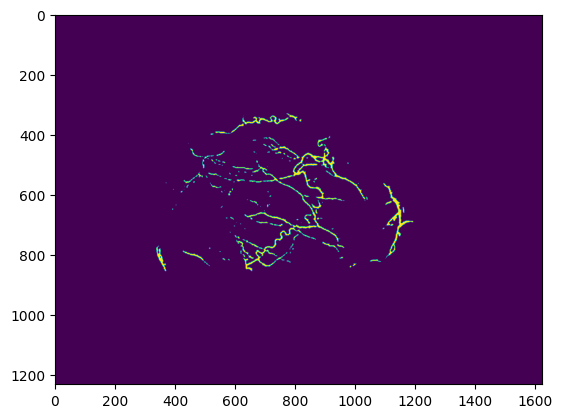

In [40]:
import matplotlib.pyplot as plt

plt.imshow(pred)

In [17]:
bone = 'densenet121'

model_path = 'large/sp1_densenet121_tuned_larger.pth' 

resolution = 900
batch_size = 1

apreds1 = get_infers(resolution, model_path, timgs, bone=bone)

model_path = 'large/sp2_densenet121_tuned_larger.pth' 

resolution = 900
batch_size = 1

apreds2 = get_infers(resolution, model_path, timgs, bone=bone)

model_path = 'large/sp3_densenet121_tuned_larger.pth' 

resolution = 900
batch_size = 1

apreds3 = get_infers(resolution, model_path, timgs, bone=bone)

model_path = 'large/sp4_densenet121_tuned_larger.pth' 

resolution = 900
batch_size = 1

apreds4 = get_infers(resolution, model_path, timgs, bone=bone)

model_path = 'large/sp5_densenet121_tuned_larger.pth' 

resolution = 900
batch_size = 1

apreds5 = get_infers(resolution, model_path, timgs, bone=bone)

100%|██████████| 301/301 [00:25<00:00, 11.86it/s]


In [15]:
import zipfile

In [ ]:
simgs = [p.stem for p in Path('data/raw/Микроциркуляция/sample_solution/').glob('*.png')]
subimgs = [p.stem for p in Path('submit/').glob('*.png')] 

In [ ]:
11-09-22:16-58 - 0.5076024792941374 - 0.5037055911809165 - 0.482606
0.482834

In [18]:
!rm submit.zip

with zipfile.ZipFile(f'submit.zip', 'w', zipfile.ZIP_DEFLATED) as f:
    for prob1, prob2, prob3, prob4, prob5, stem in tqdm(zip(apreds1, apreds2, apreds3, apreds4, apreds5, timgs)):
        prob1 = np.swapaxes(np.swapaxes(prob1, 0, 1), 1, 2)
        rprob1 = cv2.resize(prob1, (1624, 1232), interpolation=cv2.INTER_CUBIC)

        prob2 = np.swapaxes(np.swapaxes(prob2, 0, 1), 1, 2)
        rprob2 = cv2.resize(prob2, (1624, 1232), interpolation=cv2.INTER_CUBIC)

        prob3 = np.swapaxes(np.swapaxes(prob3, 0, 1), 1, 2)
        rprob3 = cv2.resize(prob3, (1624, 1232), interpolation=cv2.INTER_CUBIC)

        prob4 = np.swapaxes(np.swapaxes(prob4, 0, 1), 1, 2)
        rprob4 = cv2.resize(prob4, (1624, 1232), interpolation=cv2.INTER_CUBIC)

        prob5 = np.swapaxes(np.swapaxes(prob5, 0, 1), 1, 2)
        rprob5 = cv2.resize(prob5, (1624, 1232), interpolation=cv2.INTER_CUBIC)

        rprob = rprob1 + rprob2 + rprob3 + rprob4 + rprob5
#         rprob = rprob1 + rprob2 + rprob3
        pred = rprob.argmax(2).astype(np.uint8) * 255

        io.imsave(f'submit/{stem}.png', pred)
        f.write(f'submit/{stem}.png', f'{stem}.png')

0it [00:00, ?it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/871.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
3it [00:00,  7.44it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/847.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
5it [00:00,  7.68it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/1062.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
11it [00:01,  7.52it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/974.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
15it [00:02,  7.33it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/828.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
17it [00:02,  7.49it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/1073.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
21it [00:02,  7.73it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserW

124it [00:15,  7.25it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/946.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/923.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
130it [00:16,  7.76it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/997.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
131it [00:16,  8.20it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/958.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
134it [00:16,  8.00it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/939.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
136it [00:17,  8.12it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/1107.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
138it [00:17,  7.87it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: sub

235it [00:29,  8.20it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/893.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
236it [00:29,  8.39it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/1004.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
237it [00:29,  8.39it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/961.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
238it [00:29,  8.44it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/967.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
241it [00:30,  7.55it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/875.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
244it [00:30,  7.67it/s]/tmp/ipykernel_3464276/3553889205.py:24: UserWarning: submit/992.png is a low contrast image
  io.imsave(f'submit/{stem}.png', pred)
247it [00:31,  8.00it/s]/tmp/ipykernel_3464276/3553889205